In [1]:
import pandas as pd
import paths
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from math import ceil
import pickle

In [2]:
# labels preprocessing
df_labels = pd.read_csv(paths.labels_path)
df_labels = df_labels.rename(columns={'Participant': 'InterviewID'})
df_labels = df_labels.drop(columns=['Worker'])
df_labels = df_labels.groupby('InterviewID').mean().reset_index()
df_labels['InterviewID'] = df_labels['InterviewID'].str.upper()
# drop EyeContact column for now
df_labels = df_labels.drop(columns=['EyeContact'])

In [3]:
df_lexical = pd.read_csv(paths.pp_lexical_path)
df_emotions = pd.read_csv(paths.pp_emotions_path)
df_prosodical = pd.read_csv(paths.pp_prosodical_path2)
df_smile = pd.read_csv(paths.pp_smile_path)
df = df_lexical.merge(df_prosodical, on='InterviewID').merge(df_smile, on='InterviewID').merge(df_labels, on='InterviewID').merge(df_emotions, on='InterviewID')

In [4]:
df[df['InterviewID'] == 'P3']

,InterviewID,Filler_Words,Tentative_Language,Cognitive,Work,posEmotion,duration,meanF0Hz,stdevF0Hz,HNR,...,Focused,Authentic,NotAwkward,Total,angry,fear,happy,sad,surprise,neutral
16,P3,82,26,25,16,8,0.816807,-1.130299,1.515108,-2.194559,...,5.454983,5.901496,4.892355,91.372523,0.138091,0.048438,0.599848,0.070412,0.029024,0.112451


In [5]:
df_labels.columns

Index(['InterviewID', 'Overall', 'RecommendHiring', 'Colleague', 'Engaged',
       'Excited', 'Smiled', 'SpeakingRate', 'NoFillers', 'Friendly', 'Paused',
       'EngagingTone', 'StructuredAnswers', 'Calm', 'NotStressed', 'Focused',
       'Authentic', 'NotAwkward', 'Total'],
      dtype='object')

### Standardization

In [6]:
scaler = StandardScaler()
df.iloc[:, 1:-1] = scaler.fit_transform(df.iloc[:, 1:-1])

In [7]:
df.head()

,InterviewID,Filler_Words,Tentative_Language,Cognitive,Work,posEmotion,duration,meanF0Hz,stdevF0Hz,HNR,...,Focused,Authentic,NotAwkward,Total,angry,fear,happy,sad,surprise,neutral
0,P1,-0.310403,-0.348485,-1.041116,-0.527041,-0.755355,-0.973463,-0.930399,-1.225434,-1.121229,...,0.372554,-0.420058,0.364939,-0.046801,-0.581444,-0.795032,-0.188847,0.588549,-0.153194,0.389895
1,P10,2.441884,-0.136007,0.335951,1.275159,0.363489,0.506589,-1.356822,-1.261906,0.694011,...,-0.492900,-0.115856,-1.182820,-0.968327,-1.033557,-0.094868,-0.836402,1.962785,-0.630836,0.404729
2,P11,-0.110237,-0.702615,0.221196,1.017702,-0.568881,-0.488747,0.461690,-0.458527,0.134823,...,0.159383,-0.342821,-0.642493,-0.934447,0.721769,1.567168,-0.769819,-0.716873,-0.072909,0.373346
3,P12,-0.510569,-0.490137,-0.352582,-0.012127,0.177015,-0.921811,0.399213,0.521150,1.337175,...,-0.077562,0.678386,-0.228354,0.698136,-1.089840,-1.080456,0.782383,-1.126402,-0.527184,0.469118
4,P13,-0.060195,-0.206833,-0.582094,-0.398312,-0.941829,-0.346512,0.352528,0.370037,0.594797,...,0.167225,-0.589071,-1.457139,-1.345899,-0.247627,-0.268734,1.490056,-1.008787,0.062138,0.159422


### Random Forest Regression

In [8]:
df.columns

Index(['InterviewID', 'Filler_Words', 'Tentative_Language', 'Cognitive',
       'Work', 'posEmotion', 'duration', 'meanF0Hz', 'stdevF0Hz', 'HNR',
       'localJitter', 'localabsoluteJitter', 'rapJitter', 'ppq5Jitter',
       'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer',
       'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer', 'f1_mean', 'f2_mean',
       'f3_mean', 'f4_mean', 'f1_median', 'f2_median', 'f3_median',
       'f4_median', 'JitterPCA', 'ShimmerPCA', 'pF', 'fdisp', 'avgFormant',
       'mff', 'fitch_vtl', 'delta_f', 'vtl_delta_f', 'Smile Intensity',
       'Head Nod', 'Head Shake', 'Overall', 'RecommendHiring', 'Colleague',
       'Engaged', 'Excited', 'Smiled', 'SpeakingRate', 'NoFillers', 'Friendly',
       'Paused', 'EngagingTone', 'StructuredAnswers', 'Calm', 'NotStressed',
       'Focused', 'Authentic', 'NotAwkward', 'Total', 'angry', 'fear', 'happy',
       'sad', 'surprise', 'neutral'],
      dtype='object')

In [51]:
# X with PCA
# X = df[['Filler_Words', 'Tentative_Language', 'Cognitive', 'Work', 'posEmotion', 'Prosody_PC1', 'Prosody_PC2', 'Prosody_PC3', 'Prosody_PC4', 'Prosody_PC5', 'Prosody_PC6', 'Prosody_PC7', 'Prosody_PC8', 'Prosody_PC9', 'Prosody_PC10', 'Prosody_PC11', 'Prosody_PC12', 'Prosody_PC13', 'Prosody_PC14', 'Smile Intensity', 'Head Nod', 'Head Shake']]

# X with all features
X = df[['Filler_Words', 'Tentative_Language', 'Cognitive',
       'Work', 'posEmotion', 'duration', 'meanF0Hz', 'stdevF0Hz', 'HNR',
       'localJitter', 'localabsoluteJitter', 'rapJitter', 'ppq5Jitter',
       'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer',
       'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer', 'f1_mean', 'f2_mean',
       'f3_mean', 'f4_mean', 'f1_median', 'f2_median', 'f3_median',
       'f4_median', 'JitterPCA', 'ShimmerPCA', 'pF', 'fdisp', 'avgFormant',
       'mff', 'fitch_vtl', 'delta_f', 'vtl_delta_f', 'angry', 'fear', 'happy',
       'sad', 'surprise', 'neutral']]
# add EyeContact label back when doing video analysis
y = df[['Overall', 'RecommendHiring', 'Colleague', 'Engaged', 'Excited', 'Smiled', 'SpeakingRate', 'NoFillers', 'Friendly', 'Paused', 'EngagingTone', 'StructuredAnswers', 'Calm', 'NotStressed', 'Focused', 'Authentic', 'NotAwkward', 'Total']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
multi_output_regressor = MultiOutputRegressor(rf_regressor)
multi_output_regressor.fit(X_train, y_train)
y_pred = multi_output_regressor.predict(X_test)


In [52]:
# save model
pickle.dump(multi_output_regressor, open(paths.model_custom_path, 'wb'))

In [53]:
print(len(X_train),len(y_train),len(X_test),len(y_test))

110 110 28 28


In [54]:
for i, target in enumerate(y_test.columns):
    mse = mean_squared_error(y_test[target], y_pred[:, i])
    print(f"Target: {target}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-Squared: {r2_score(y_test[target], y_pred[:, i])}")
    print()

Target: Overall
Mean Squared Error: 0.9442893027910364
R-Squared: 0.04315170946258229

Target: RecommendHiring
Mean Squared Error: 0.9163996635896758
R-Squared: -0.02296045686643433

Target: Colleague
Mean Squared Error: 1.0284741637646042
R-Squared: -0.16816545136525574

Target: Engaged
Mean Squared Error: 0.8520973432606257
R-Squared: -0.06106137340544171

Target: Excited
Mean Squared Error: 1.1174825663235506
R-Squared: 0.02646373468973484

Target: Smiled
Mean Squared Error: 0.6953625276537563
R-Squared: -0.14263744132415068

Target: SpeakingRate
Mean Squared Error: 1.111785656795203
R-Squared: -0.18286817594308924

Target: NoFillers
Mean Squared Error: 0.35421789428252154
R-Squared: 0.20544956708004103

Target: Friendly
Mean Squared Error: 1.0926910681055513
R-Squared: -0.06514947212162281

Target: Paused
Mean Squared Error: 1.0515402400048652
R-Squared: 0.1341399299873356

Target: EngagingTone
Mean Squared Error: 1.115919095620349
R-Squared: 0.11246616308489477

Target: Structured

In [55]:
# Get the base estimator (RandomForestRegressor)
base_estimator = multi_output_regressor.estimators_

# Iterate through target variables and print the top 20 features and their importances
for i, target in enumerate(y.columns):
    # Get feature importances for the i-th target
    importances = base_estimator[i].feature_importances_
    indices = importances.argsort()[::-1]

    print(f"Top 20 features for target variable: {target}")
    for f in range(20):
        print(f"{X.columns[indices[f]]}: {importances[indices[f]]}")
    print()

Top 20 features for target variable: Overall
f3_mean: 0.08542093208954755
Filler_Words: 0.0764093006357262
Tentative_Language: 0.04238517422122587
ShimmerPCA: 0.0413561537709444
neutral: 0.03728127300004161
posEmotion: 0.036595294193459825
fitch_vtl: 0.03515117412770204
duration: 0.034602159174517366
angry: 0.03422493436907789
f1_median: 0.03184444665114796
mff: 0.030641963774461337
happy: 0.026353976650057717
f3_median: 0.025741452388264446
JitterPCA: 0.024472408556782753
avgFormant: 0.024389935160662016
Work: 0.02304865511074564
HNR: 0.022660406493863604
surprise: 0.022325610118741356
ppq5Jitter: 0.021647147023231953
apq11Shimmer: 0.02010502723369328

Top 20 features for target variable: RecommendHiring
f3_mean: 0.0744857052881736
duration: 0.05438744710962416
posEmotion: 0.05195456781594481
Filler_Words: 0.048265676019073535
Tentative_Language: 0.04644187552987512
HNR: 0.03897181734936885
happy: 0.03756271617224024
neutral: 0.03699181905897055
ShimmerPCA: 0.03320950463668917
JitterP

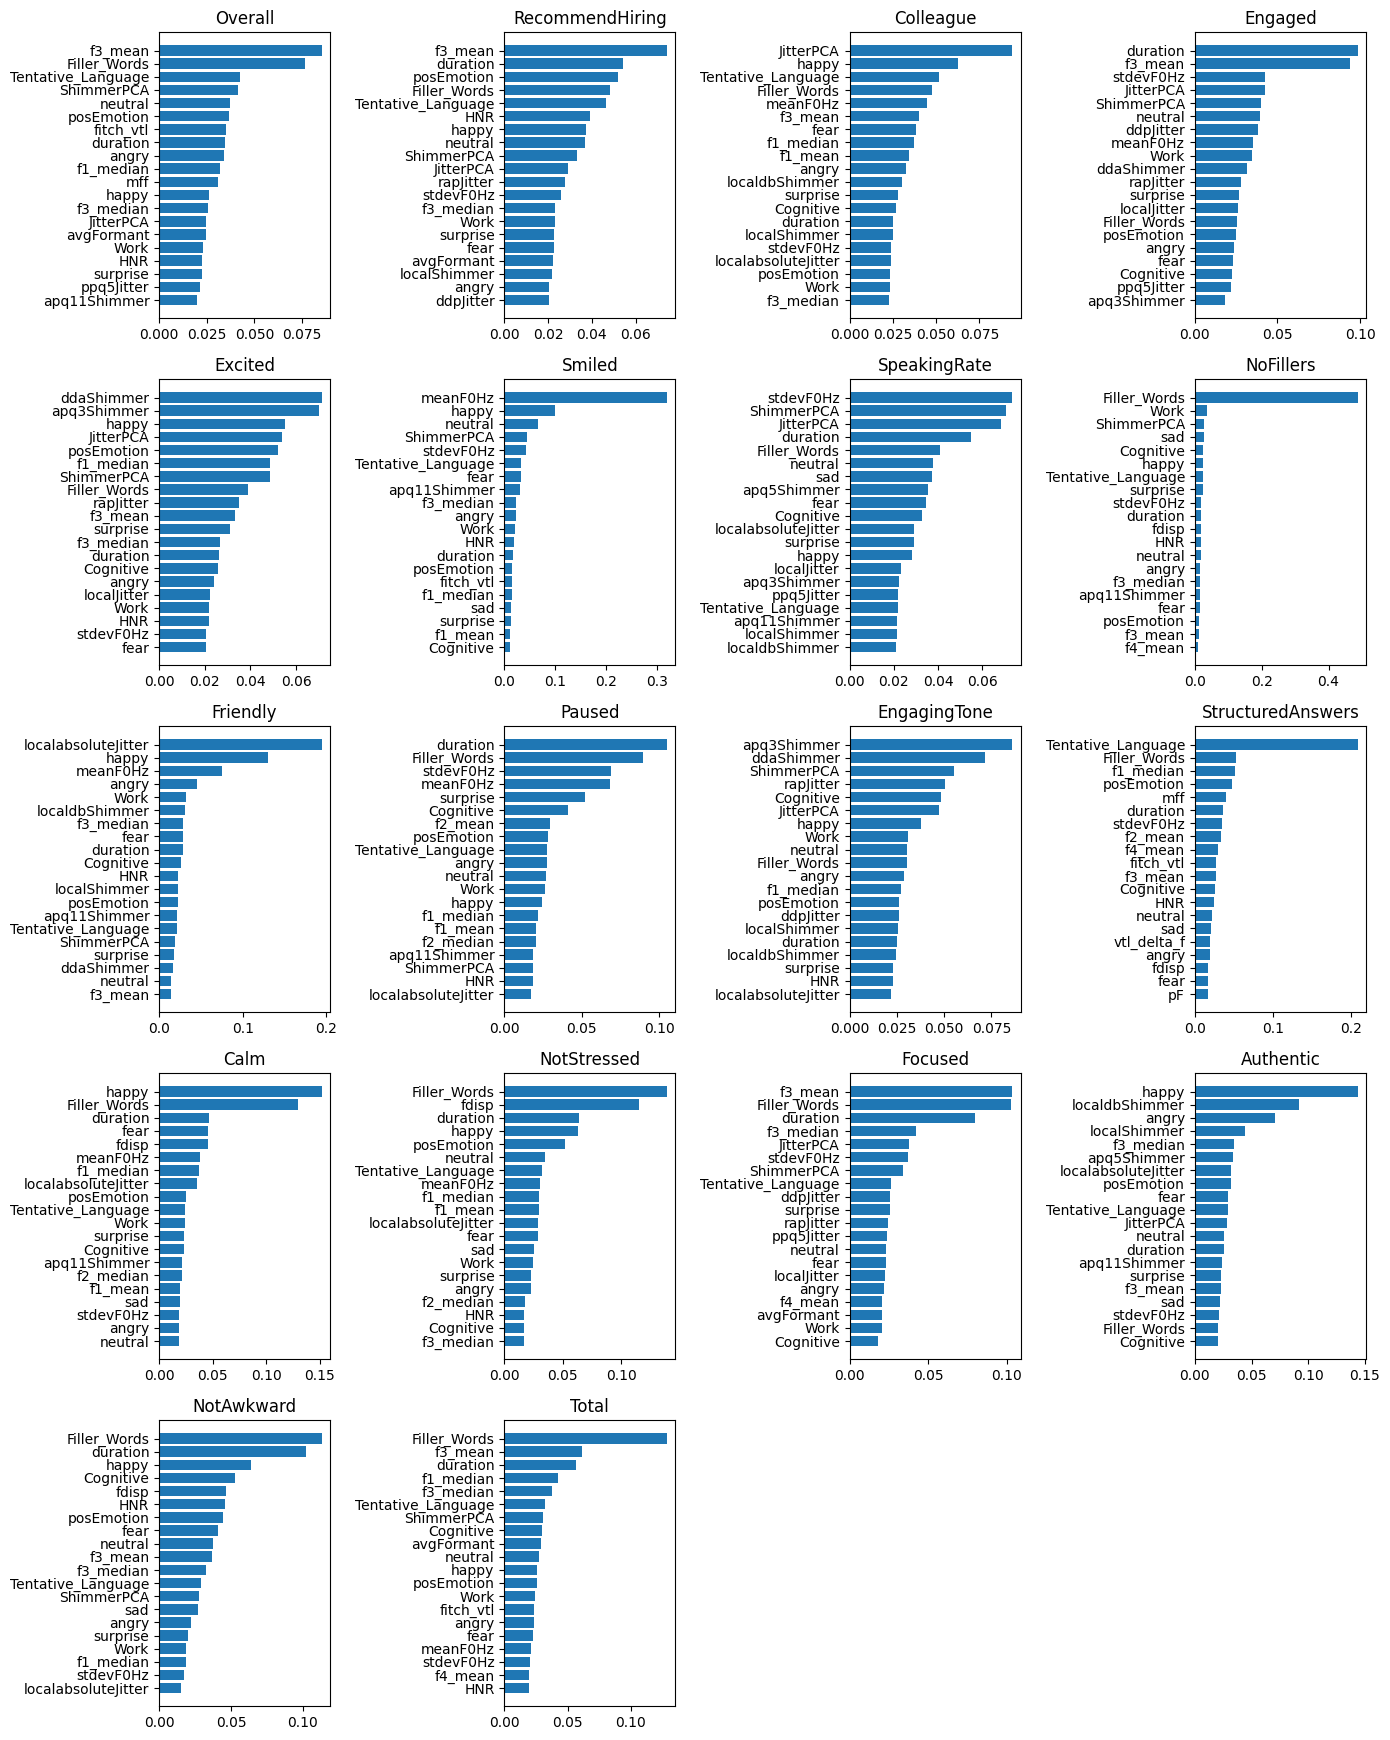

In [56]:
# Get feature importances for each target variable
importances = []
for estimator in multi_output_regressor.estimators_:
    importances.append(estimator.feature_importances_)

# Define the number of top features to display
top_features = 20

# Calculate the number of rows and columns for subplots
N = len(y.columns)
nrows = ceil(N / 4)
ncols = 4

# Create a grid of subplots based on the number of target variables
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5 * ncols, 3.5 * nrows))

# Iterate through target variables and create subplots
for i, (target, ax) in enumerate(zip(y.columns, axs.flat)):
    ax.set_title(target)
    
    # Get the feature importances for the i-th target
    target_importances = importances[i]
    indices = target_importances.argsort()[::-1]
    
    ax.barh(range(top_features), target_importances[indices][:top_features])
    ax.set_yticks(range(top_features))
    ax.set_yticklabels(X.columns[indices][:top_features])
    ax.invert_yaxis()

# Remove any remaining empty subplots
for i in range(N, nrows * ncols):
    fig.delaxes(axs.flat[i])

plt.tight_layout()
plt.show()


### Binary Classification


In [57]:
len(X_train)

110

In [58]:
labels = ['Overall', 'RecommendHiring', 'Colleague', 'Engaged', 'Excited', 'Smiled', 'SpeakingRate', 'NoFillers', 'Friendly', 'Paused', 'EngagingTone', 'StructuredAnswers', 'Calm', 'NotStressed', 'Focused', 'Authentic', 'NotAwkward', 'Total']
medians = y_train.median()

y_pred_test = pd.DataFrame(y_pred, columns=y_test.columns)
y_pred_train = multi_output_regressor.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, columns=y_train.columns)

true_labels_binary_train = (y_train > medians).astype(int)
true_labels_binary_test = (y_test > medians).astype(int)
pred_labels_binary_train = (y_pred_train > medians).astype(int)
pred_labels_binary_test = (y_pred_test > medians).astype(int)


In [59]:
len(true_labels_binary_train)

110

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC AUC for both the training and testing data
roc_auc_train = roc_auc_score(true_labels_binary_train['Overall'], pred_labels_binary_train['Overall'])
roc_auc_test = roc_auc_score(true_labels_binary_test['Overall'], pred_labels_binary_test['Overall'])
roc_auc_train, roc_auc_test

# Plot the ROC curve
# fpr_train, tpr_train, _ = roc_curve(true_labels_binary_train, pred_labels_binary_train)
# fpr_test, tpr_test, _ = roc_curve(true_labels_binary_test, pred_labels_binary_test)



(0.9181818181818181, 0.6128205128205128)

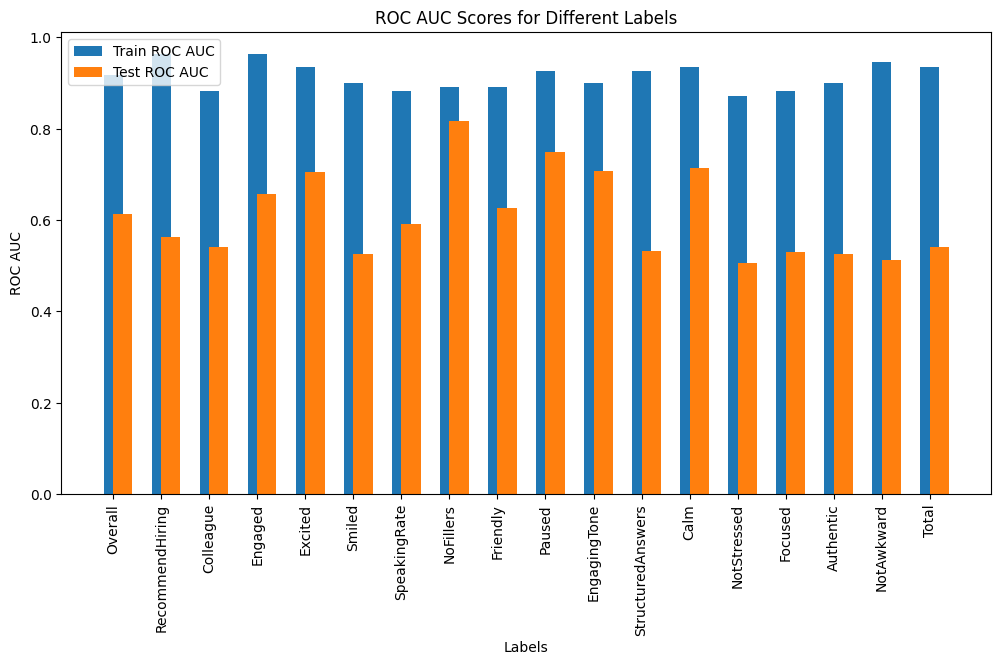

In [61]:
from sklearn.metrics import roc_auc_score

roc_auc_scores_train = []
roc_auc_scores_test = []

for label in labels:  # Iterate through your labels
    roc_auc_train = roc_auc_score(true_labels_binary_train[label], pred_labels_binary_train[label])
    roc_auc_test = roc_auc_score(true_labels_binary_test[label], pred_labels_binary_test[label])
    roc_auc_scores_train.append(roc_auc_train)
    roc_auc_scores_test.append(roc_auc_test)


plt.figure(figsize=(12, 6))
plt.bar(labels, roc_auc_scores_train, width=0.4, label='Train ROC AUC', align='center')
plt.bar(labels, roc_auc_scores_test, width=0.4, label='Test ROC AUC', align='edge')
plt.xlabel('Labels')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Scores for Different Labels')
plt.xticks(rotation=90)
plt.legend()
plt.show()


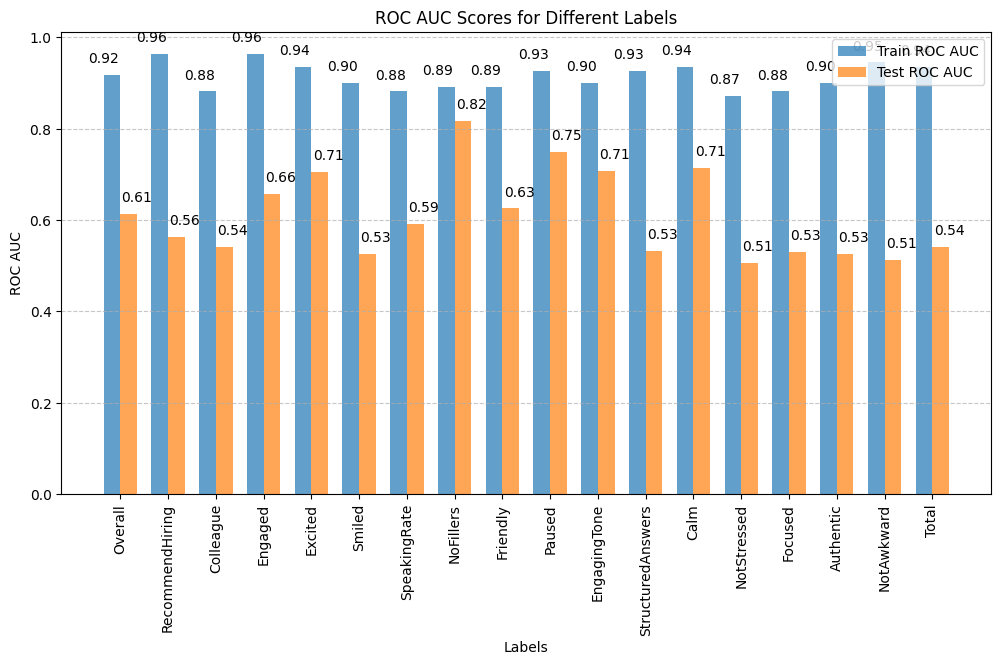

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have calculated roc_auc_scores_train and roc_auc_scores_test

# Set the figure size and create a new figure
plt.figure(figsize=(12, 6))

# Create an array for x-axis positions
x = np.arange(len(labels))

# Bar width
width = 0.35

# Plot the bars for train and test ROC AUC
plt.bar(x - width/2, roc_auc_scores_train, width, label='Train ROC AUC', alpha=0.7)
plt.bar(x + width/2, roc_auc_scores_test, width, label='Test ROC AUC', alpha=0.7)

# Beautify the graph
plt.xlabel('Labels')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Scores for Different Labels')
plt.xticks(x, labels, rotation=90)
plt.legend(loc='upper right')

# Add grid lines for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data values above the bars
for i in range(len(labels)):
    plt.text(x[i] - width, roc_auc_scores_train[i] + 0.02, f'{roc_auc_scores_train[i]:.2f}', ha='center', va='bottom')
    plt.text(x[i] + width, roc_auc_scores_test[i] + 0.02, f'{roc_auc_scores_test[i]:.2f}', ha='center', va='bottom')

plt.show()


In [63]:
from sklearn.metrics import roc_auc_score
from prettytable import PrettyTable

roc_auc_table = PrettyTable()
roc_auc_table.field_names = ["Label", "Train ROC AUC", "Test ROC AUC"]

roc_auc_data = []  # Create a list to store the data

for label in labels:  # Iterate through your labels
    roc_auc_train = roc_auc_score(true_labels_binary_train[label], pred_labels_binary_train[label])
    roc_auc_test = roc_auc_score(true_labels_binary_test[label], pred_labels_binary_test[label])
    roc_auc_data.append([label, roc_auc_train, roc_auc_test])

# Sort the data by the test ROC AUC values in descending order
roc_auc_data.sort(key=lambda x: x[2], reverse=True)

# Add the sorted data to the table
for row in roc_auc_data:
    roc_auc_table.add_row([row[0], f'{row[1]:.4f}', f'{row[2]:.4f}'])

print(roc_auc_table)


+-------------------+---------------+--------------+
|       Label       | Train ROC AUC | Test ROC AUC |
+-------------------+---------------+--------------+
|     NoFillers     |     0.8909    |    0.8179    |
|       Paused      |     0.9273    |    0.7500    |
|        Calm       |     0.9364    |    0.7143    |
|    EngagingTone   |     0.9000    |    0.7076    |
|      Excited      |     0.9364    |    0.7056    |
|      Engaged      |     0.9636    |    0.6578    |
|      Friendly     |     0.8909    |    0.6257    |
|      Overall      |     0.9182    |    0.6128    |
|    SpeakingRate   |     0.8818    |    0.5923    |
|  RecommendHiring  |     0.9636    |    0.5641    |
|     Colleague     |     0.8818    |    0.5417    |
|       Total       |     0.9364    |    0.5417    |
| StructuredAnswers |     0.9273    |    0.5333    |
|      Focused      |     0.8818    |    0.5312    |
|       Smiled      |     0.9000    |    0.5250    |
|     Authentic     |     0.9000    |    0.525

In [64]:
roc_auc_table

Label,Train ROC AUC,Test ROC AUC
NoFillers,0.8909,0.8179
Paused,0.9273,0.7500
Calm,0.9364,0.7143
EngagingTone,0.9000,0.7076
Excited,0.9364,0.7056
Engaged,0.9636,0.6578
Friendly,0.8909,0.6257
Overall,0.9182,0.6128
SpeakingRate,0.8818,0.5923
RecommendHiring,0.9636,0.5641
